**Book Recommendation Based on Client Data By RB**

In [638]:
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install -U scikit-learn scipy matplotlib
#!pip install scipy

In [639]:
#Importing modules
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import model_selection,SVD,Reader,Dataset,accuracy
from surprise.model_selection import cross_validate, KFold,train_test_split
import requests
from PIL import Image
from io import BytesIO
import gc
import warnings
warnings.filterwarnings("ignore")


**#User Data Preparation**

In [640]:
tags = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_tags.csv')
users_intrested_tag = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_user_interested_tag.csv')
users_media_records = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_user_media_record.csv')

In [641]:
users_media_records['Age'] = np.random.randint(10, 100, users_media_records.shape[0])
def flag_df(df):
    
    if (df['type'] ==0):
        return 'event'
    elif (df['type'] ==1):
        return 'bookbite'
    elif (df['type']==2):
        return 'conversation'
    elif (df['type']==3):
        return 'podcast'
    elif (df['type']==4):
        return 'ideaofday'
    elif (df['type']==5):
        return 'ecourse'
    elif (df['type'] ==6):
        return 'audiobookchapter'
    
users_media_records['type'] = users_media_records.apply(flag_df, axis = 1)
users_media_records.drop(['created_at', 'updated_at'], axis=1, inplace=True)
users_media_records

,id,user_id,media_id,leave_time,type,Age
0,2,14849,173,382,bookbite,92
1,4,11694,76,175,bookbite,31
2,6,11694,158,314,bookbite,56
3,7,11694,gid://art19-episode-locator/V0/WIhT5CD0BW2EVzF...,1323,podcast,29
4,8,11694,147,323,bookbite,55
...,...,...,...,...,...,...
28343,39039,42280,996,667,bookbite,91
28344,39040,36968,993,47,bookbite,15
28345,39041,57644,995,179,bookbite,58
28346,39042,57662,995,114,bookbite,76


In [642]:

## Checking null values
print(users_media_records.isna().sum())  

id            0
user_id       0
media_id      0
leave_time    0
type          0
Age           0
dtype: int64


In [643]:
## Drop duplicate rows
users_media_records.drop_duplicates(keep='last', inplace=True)
users_media_records.reset_index(drop=True, inplace=True)
     

In [644]:
# Users dataset information
users_media_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28348 entries, 0 to 28347
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          28348 non-null  int64 
 1   user_id     28348 non-null  int64 
 2   media_id    28348 non-null  object
 3   leave_time  28348 non-null  int64 
 4   type        28348 non-null  object
 5   Age         28348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.3+ MB


In [645]:
# Checking for any duplicate values 
len(users_media_records[users_media_records.duplicated()])
# No duplicate

0

In [646]:
users_media_records.head()

,id,user_id,media_id,leave_time,type,Age
0,2,14849,173,382,bookbite,92
1,4,11694,76,175,bookbite,31
2,6,11694,158,314,bookbite,56
3,7,11694,gid://art19-episode-locator/V0/WIhT5CD0BW2EVzF...,1323,podcast,29
4,8,11694,147,323,bookbite,55


In [647]:
#users_media_records.drop(['leave_time', 'type','Age'], axis=1, inplace=True)
#users_media_records.head(3)

In [648]:
'''#printing the shape of all three data sets
print("tags Data:    ", tags.shape)
print("users_intrested_tag Data:    ", users_intrested_tag.shape)
print("users_media_records: ", users_media_records.shape)'''

'#printing the shape of all three data sets\nprint("tags Data:    ", tags.shape)\nprint("users_intrested_tag Data:    ", users_intrested_tag.shape)\nprint("users_media_records: ", users_media_records.shape)'

In [649]:
'''#Rename id to tag id in tag DB
tags.rename(columns={"id": "tag_id"}, inplace=True)
tags'''

'#Rename id to tag id in tag DB\ntags.rename(columns={"id": "tag_id"}, inplace=True)\ntags'

In [650]:
'''#merging both db so we can get tag names and delete irrelevant cols
users_intrested_tagnames = pd.merge(users_intrested_tag,tags[['tag_id','tagName']],on='tag_id', how='left')
users_intrested_tagnames.drop(['created_at', 'updated_at'], axis=1, inplace=True)
users_intrested_tagnames'''

"#merging both db so we can get tag names and delete irrelevant cols\nusers_intrested_tagnames = pd.merge(users_intrested_tag,tags[['tag_id','tagName']],on='tag_id', how='left')\nusers_intrested_tagnames.drop(['created_at', 'updated_at'], axis=1, inplace=True)\nusers_intrested_tagnames"

**Book Data prepartion : ITEAMS_SEARCH Table prepared as per recommendatio_data_preparation file**

In [651]:
BPC = pd.read_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/ITEMS_SEARCH_Table.csv')
BPC

,ITEM_ID,TITLE,AUTHOR_NAME,CATEGORY,CREATION_TIMESTAMP
0,gid://art19-episode-locator/V0/O9qUiVxFA9ic_f1...,Book Bite #4: Is Your Inner Child Your Truest ...,Stefanie Stahl,podcast,2022
1,gid://art19-episode-locator/V0/KKlzUp47OYeDibY...,Book Bite #5: Is It Time To Rethink Everything...,Adam Grant,podcast,2022
2,gid://art19-episode-locator/V0/gb8ERjyqL5AJ3cE...,Book Bite #6: Want to Know the Secret to Getti...,Annie Murphy Paul,podcast,2022
3,gid://art19-episode-locator/V0/77A3nksFpz8oysc...,Book Bite #7: Why Won’t the Voice in Your Head...,Ethan Kross,podcast,2022
4,gid://art19-episode-locator/V0/tEJB-uRC98ywB9N...,Book Bite #8: What if Being Delusional Is Good...,Shankar Vedantam,podcast,2022
...,...,...,...,...,...
1208,f0735625-ca0f-4d69-a1bd-1001a8792a08,Ethan Kross on Harnessing the Chatter in Our M...,NaN,ecourse,2021
1209,f37ad137-ac1e-4f45-a410-65e93fdf1588,Olga Khazan on The Power of Being an Outsider ...,NaN,ecourse,2021
1210,f40915eb-df24-455d-8605-c3082548d00f,Your Brain on Art: An Audio E-Course by Ivy Ro...,"Ivy Ross, Susan Magsamen",ecourse,2023
1211,f7170c76-708a-4e8b-bed2-99ea144d560d,Safi Bahcall on Nurturing the Ideas That Win W...,NaN,ecourse,2021


In [652]:
BPC.isnull().sum()

ITEM_ID                0
TITLE                  0
AUTHOR_NAME           51
CATEGORY               0
CREATION_TIMESTAMP     0
dtype: int64

In [653]:
BPC.loc[BPC['AUTHOR_NAME'].isnull(),:]

,ITEM_ID,TITLE,AUTHOR_NAME,CATEGORY,CREATION_TIMESTAMP
103,gid://art19-episode-locator/V0/ASrtVpX-SPOvI0L...,Introducing The Next Big Idea,NaN,podcast,2022
120,p123,CULTURE: How Successful Groups Work,NaN,podcast,2022
122,p125,How To Be a Grown-Up,NaN,podcast,2022
124,p127,"Susan Cain & Daniel Pink: Writing, Longing, an...",NaN,podcast,2022
125,p128,"BIG DATA: Cracking the Codes of Love, Happines...",NaN,podcast,2022
127,p130,THE ESSENTIALS: Our Favorite Moments From Seas...,NaN,podcast,2022
128,p131,Summer Getaway #1: The Beach (with Sarah Stodola),NaN,podcast,2022
129,p132,Summer Getaway #2: An American Odyssey (with B...,NaN,podcast,2022
131,p134,Summer Getaway #4: The Making of ‘Bull Durham’...,NaN,podcast,2022
132,p135,HAPPINESS: Arthur C. Brooks Shares His Roadmap...,NaN,podcast,2022


In [654]:
BPC.fillna('Other')

,ITEM_ID,TITLE,AUTHOR_NAME,CATEGORY,CREATION_TIMESTAMP
0,gid://art19-episode-locator/V0/O9qUiVxFA9ic_f1...,Book Bite #4: Is Your Inner Child Your Truest ...,Stefanie Stahl,podcast,2022
1,gid://art19-episode-locator/V0/KKlzUp47OYeDibY...,Book Bite #5: Is It Time To Rethink Everything...,Adam Grant,podcast,2022
2,gid://art19-episode-locator/V0/gb8ERjyqL5AJ3cE...,Book Bite #6: Want to Know the Secret to Getti...,Annie Murphy Paul,podcast,2022
3,gid://art19-episode-locator/V0/77A3nksFpz8oysc...,Book Bite #7: Why Won’t the Voice in Your Head...,Ethan Kross,podcast,2022
4,gid://art19-episode-locator/V0/tEJB-uRC98ywB9N...,Book Bite #8: What if Being Delusional Is Good...,Shankar Vedantam,podcast,2022
...,...,...,...,...,...
1208,f0735625-ca0f-4d69-a1bd-1001a8792a08,Ethan Kross on Harnessing the Chatter in Our M...,Other,ecourse,2021
1209,f37ad137-ac1e-4f45-a410-65e93fdf1588,Olga Khazan on The Power of Being an Outsider ...,Other,ecourse,2021
1210,f40915eb-df24-455d-8605-c3082548d00f,Your Brain on Art: An Audio E-Course by Ivy Ro...,"Ivy Ross, Susan Magsamen",ecourse,2023
1211,f7170c76-708a-4e8b-bed2-99ea144d560d,Safi Bahcall on Nurturing the Ideas That Win W...,Other,ecourse,2021


In [655]:
## Checking for column Year-of-publication
BPC['CREATION_TIMESTAMP'].unique()

array([2022, 2023, 2020, 2021])

In [656]:
## Uppercasing all alphabets in Id
BPC['ITEM_ID'] = BPC['ITEM_ID'].str.upper()

In [657]:
#checking info
BPC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ITEM_ID             1213 non-null   object
 1   TITLE               1213 non-null   object
 2   AUTHOR_NAME         1162 non-null   object
 3   CATEGORY            1213 non-null   object
 4   CREATION_TIMESTAMP  1213 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 47.5+ KB


In [658]:
## Drop duplicate rows
BPC.drop_duplicates(keep='last', inplace=True) 
BPC.reset_index(drop = True, inplace = True)

In [659]:
#checking info
BPC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ITEM_ID             1213 non-null   object
 1   TITLE               1213 non-null   object
 2   AUTHOR_NAME         1162 non-null   object
 3   CATEGORY            1213 non-null   object
 4   CREATION_TIMESTAMP  1213 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 47.5+ KB


In [660]:
BPC.rename(columns={'ITEM_ID': 'media_id', 'CATEGORY': 'type'}, inplace=True)


In [661]:

BPC["TITLE"]=BPC["TITLE"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
BPC.head()

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022


In [662]:
#printing top5 rows
BPC.head()
     

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022


In [663]:
BPC.to_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/BPC.csv', index=False)
BPC

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022
...,...,...,...,...,...
1208,F0735625-CA0F-4D69-A1BD-1001A8792A08,Ethan Kross on Harnessing the Chatter in Our M...,NaN,ecourse,2021
1209,F37AD137-AC1E-4F45-A410-65E93FDF1588,Olga Khazan on The Power of Being an Outsider ...,NaN,ecourse,2021
1210,F40915EB-DF24-455D-8605-C3082548D00F,Your Brain on Art An Audio E Course by Ivy Ros...,"Ivy Ross, Susan Magsamen",ecourse,2023
1211,F7170C76-708A-4E8B-BED2-99EA144D560D,Safi Bahcall on Nurturing the Ideas That Win W...,NaN,ecourse,2021


**Book Likes/Completed Data Preparation**

In [664]:
likes = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_like.csv')
likes.head()

,id,user_id,media_id,type,created_at,updated_at
0,14,26630,676,1,2023-03-21 10:47:28,2023-03-21 10:47:28
1,16,26630,734,1,2023-03-21 10:48:01,2023-03-21 10:48:01
2,19,43193,58,1,2023-03-21 10:55:25,2023-03-21 10:55:25
3,23,26630,382,1,2023-03-21 19:54:48,2023-03-21 19:54:48
4,27,26630,131,1,2023-03-21 19:55:04,2023-03-21 19:55:04


In [665]:
def flag_df(df):
    
    if (df['type'] ==0):
        return 'event'
    elif (df['type'] ==1):
        return 'bookbite'
    elif (df['type']==2):
        return 'conversation'
    elif (df['type']==3):
        return 'podcast'
    elif (df['type']==4):
        return 'ideaofday'
    elif (df['type']==5):
        return 'ecourse'
    elif (df['type'] ==6):
        return 'audiobookchapter'
    
likes['type'] = likes.apply(flag_df, axis = 1)
likes.drop(['created_at', 'updated_at'], axis=1, inplace=True)
likes['liked'] = 5
likes.head()

,id,user_id,media_id,type,liked
0,14,26630,676,bookbite,5
1,16,26630,734,bookbite,5
2,19,43193,58,bookbite,5
3,23,26630,382,bookbite,5
4,27,26630,131,bookbite,5


In [666]:
completed = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_completed_media.csv')
completed.head()

,id,user_id,media_id,type,created_at,updated_at
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,3,2022-02-16 07:08:27,2022-02-16 07:08:27
1,2,14849,351,1,2022-02-16 07:32:42,2022-02-16 07:32:46
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,3,2022-02-16 07:34:12,2022-02-16 07:34:12
3,4,22862,340,1,2022-02-16 08:23:20,2022-02-16 08:23:20
4,5,1333,149,1,2022-02-16 10:33:25,2022-02-16 10:33:25


In [667]:
def flag_df(df):
    
    if (df['type'] ==0):
        return 'event'
    elif (df['type'] ==1):
        return 'bookbite'
    elif (df['type']==2):
        return 'conversation'
    elif (df['type']==3):
        return 'podcast'
    elif (df['type']==4):
        return 'ideaofday'
    elif (df['type']==5):
        return 'ecourse'
    elif (df['type'] ==6):
        return 'audiobookchapter'
    
completed['type'] = completed.apply(flag_df, axis = 1)
completed.drop(['created_at', 'updated_at'], axis=1, inplace=True)
completed['liked'] = 5
completed.head()

,id,user_id,media_id,type,liked
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5
1,2,14849,351,bookbite,5
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5
3,4,22862,340,bookbite,5
4,5,1333,149,bookbite,5


In [668]:
merged_df = pd.concat([completed, likes,users_media_records], ignore_index=True)
merged_df.fillna(0, inplace=True)
merged_df

,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0
...,...,...,...,...,...,...,...
119490,39039,42280,996,bookbite,0.0,667.0,91.0
119491,39040,36968,993,bookbite,0.0,47.0,15.0
119492,39041,57644,995,bookbite,0.0,179.0,58.0
119493,39042,57662,995,bookbite,0.0,114.0,76.0


In [669]:
## Checking for null values
merged_df.isnull().sum() 

id            0
user_id       0
media_id      0
type          0
liked         0
leave_time    0
Age           0
dtype: int64

In [670]:
## checking all ratings number or not
print(is_numeric_dtype(merged_df['liked']))

True


In [671]:
## Drop duplicate rows
merged_df.drop_duplicates(keep='last', inplace=True)
merged_df.reset_index(drop=True, inplace=True)
merged_df.head()

,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0


In [672]:
#Print a concise summary of a DataFrame
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119495 entries, 0 to 119494
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          119495 non-null  int64  
 1   user_id     119495 non-null  int64  
 2   media_id    119495 non-null  object 
 3   type        119495 non-null  object 
 4   liked       119495 non-null  float64
 5   leave_time  119495 non-null  float64
 6   Age         119495 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 6.4+ MB


In [673]:
merged_df.to_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/merged.csv', index=False)
merged_df

,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0
...,...,...,...,...,...,...,...
119490,39039,42280,996,bookbite,0.0,667.0,91.0
119491,39040,36968,993,bookbite,0.0,47.0,15.0
119492,39041,57644,995,bookbite,0.0,179.0,58.0
119493,39042,57662,995,bookbite,0.0,114.0,76.0


In [674]:

merged_df.loc[(merged_df['user_id'] == 26448 )]

,id,user_id,media_id,type,liked,leave_time,Age
1060,1061,26448,110,podcast,5.0,0.0,0.0
1062,1063,26448,108,podcast,5.0,0.0,0.0
1796,1797,26448,107,podcast,5.0,0.0,0.0
1798,1799,26448,106,podcast,5.0,0.0,0.0
2731,2732,26448,70,bookbite,5.0,0.0,0.0
...,...,...,...,...,...,...,...
115163,32314,26448,721,bookbite,0.0,38.0,81.0
116312,34069,26448,1187,bookbite,0.0,40.0,58.0
116579,34482,26448,819,bookbite,0.0,221.0,68.0
118590,37634,26448,925,bookbite,0.0,231.0,76.0


In [675]:
rating = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/interactions_db.csv')
rating.head(10)

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_TYPE,EVENT_VALUE
0,0,160,1649377965,NaN,5.000000
1,0,170,1625157204,NaN,0.172941
2,0,gid://art19-episode-locator/V0/EpdqSE9YxMHJX8T...,1624841818,NaN,0.917152
3,0,gid://art19-episode-locator/V0/kudndFcsEIzVTwH...,1624577883,NaN,0.982359
4,0,gid://art19-episode-locator/V0/s0rel2DVaE5WhO9...,1625077652,NaN,1.382107
5,0,gid://art19-episode-locator/V0/sYIF0eIsG9z64E2...,1624109358,NaN,0.839187
6,141,55,1690260755,NaN,5.000000
7,141,649,1690288226,NaN,5.000000
8,141,747,1692207009,NaN,5.000000
9,141,787,1694538333,NaN,5.000000


In [676]:
rating.rename(columns={'ITEM_ID': 'media_id', 'USER_ID': 'user_id', 'EVENT_VALUE': 'liked'}, inplace=True)
rating

,user_id,media_id,TIMESTAMP,EVENT_TYPE,liked
0,0,160,1649377965,NaN,5.000000
1,0,170,1625157204,NaN,0.172941
2,0,gid://art19-episode-locator/V0/EpdqSE9YxMHJX8T...,1624841818,NaN,0.917152
3,0,gid://art19-episode-locator/V0/kudndFcsEIzVTwH...,1624577883,NaN,0.982359
4,0,gid://art19-episode-locator/V0/s0rel2DVaE5WhO9...,1625077652,NaN,1.382107
...,...,...,...,...,...
119490,57735,986,1699047016,NaN,5.000000
119491,57754,1001,1699083832,NaN,5.000000
119492,57754,7,1699082949,NaN,5.000000
119493,57768,p208,1699122575,NaN,5.000000


In [677]:
rating.to_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/rating.csv', index=False)
rating

,user_id,media_id,TIMESTAMP,EVENT_TYPE,liked
0,0,160,1649377965,NaN,5.000000
1,0,170,1625157204,NaN,0.172941
2,0,gid://art19-episode-locator/V0/EpdqSE9YxMHJX8T...,1624841818,NaN,0.917152
3,0,gid://art19-episode-locator/V0/kudndFcsEIzVTwH...,1624577883,NaN,0.982359
4,0,gid://art19-episode-locator/V0/s0rel2DVaE5WhO9...,1625077652,NaN,1.382107
...,...,...,...,...,...
119490,57735,986,1699047016,NaN,5.000000
119491,57754,1001,1699083832,NaN,5.000000
119492,57754,7,1699082949,NaN,5.000000
119493,57768,p208,1699122575,NaN,5.000000


**Data Visualization**

Text(0.5, 1.0, 'No of books by an author (Top 15)')

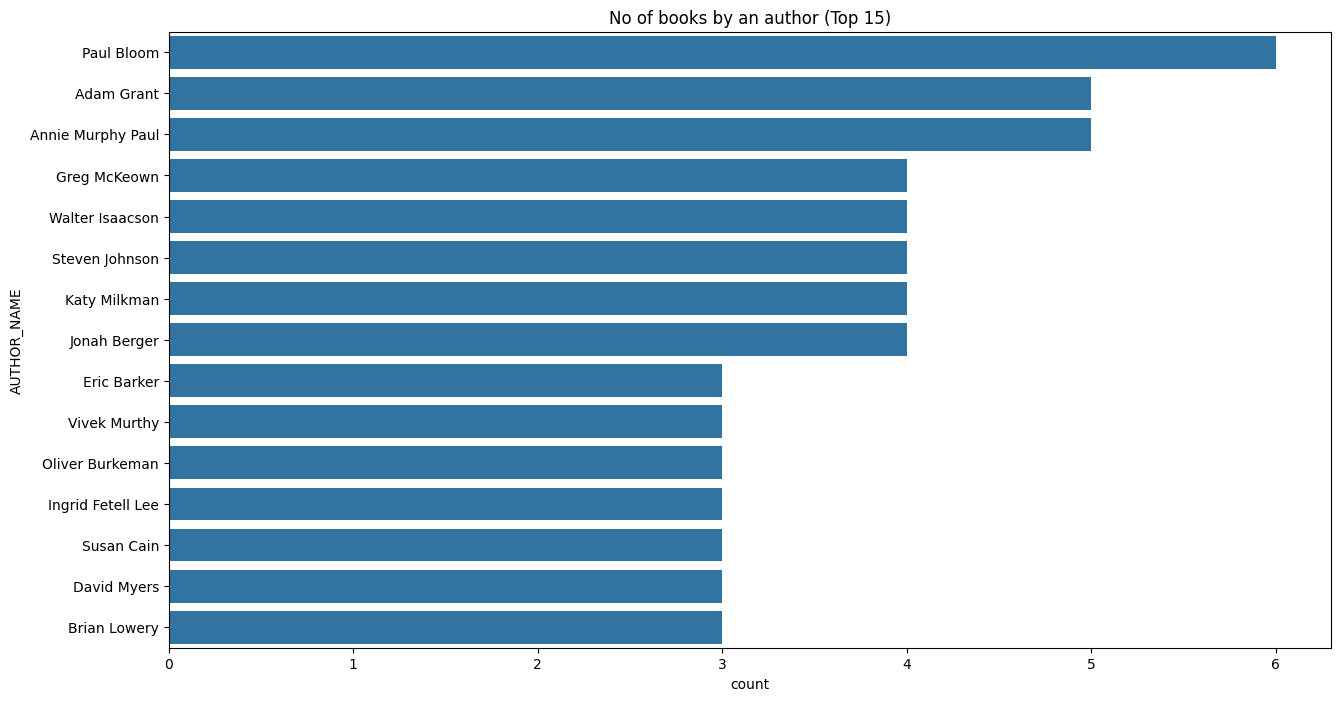

In [678]:
plt.figure(figsize=(15,8))
sns.countplot(y=BPC['AUTHOR_NAME'], data=BPC,order=BPC['AUTHOR_NAME'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

#Additionally there are many visuals we can implement such as top 15 books, type, year of book published,  author, users

Text(0.5, 1.0, 'Explicit Ratings/Liked')

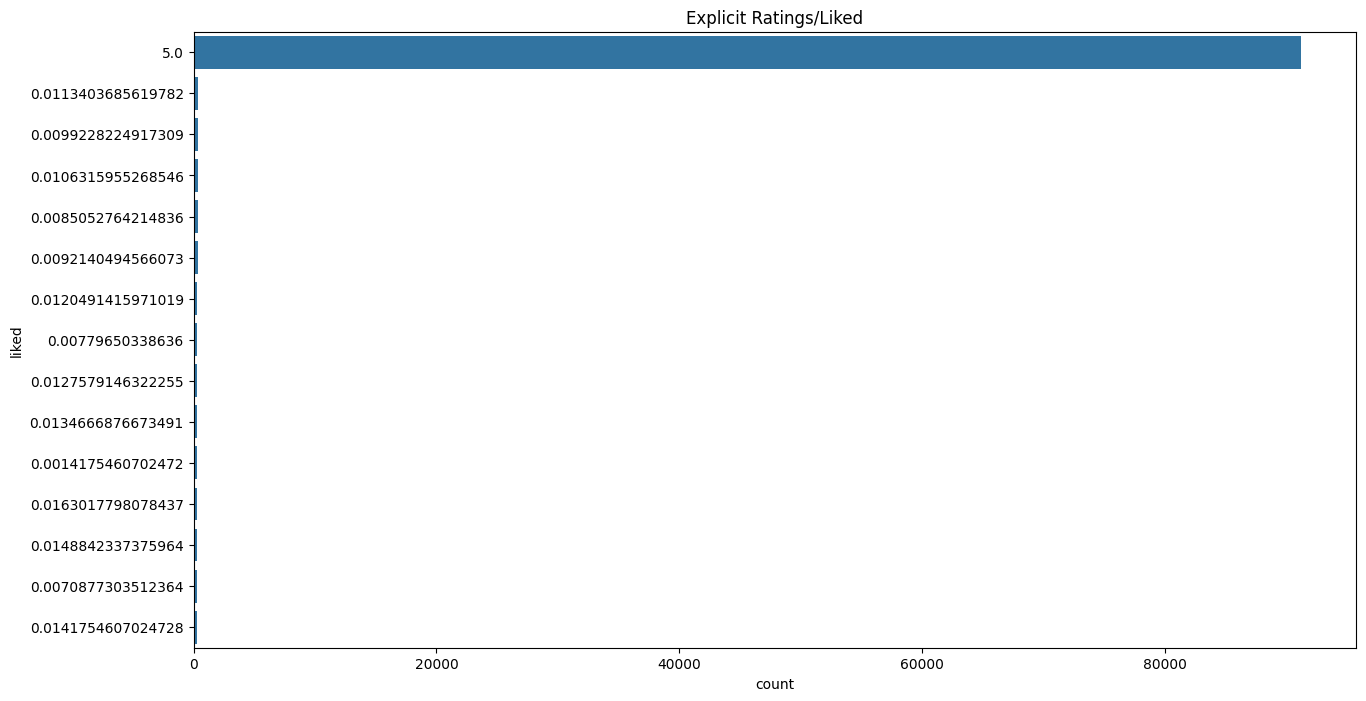

In [679]:
plt.figure(figsize=(15,8))
sns.countplot(y=rating['liked'], data=rating,order=rating['liked'].value_counts().index[0:15])
plt.title("Explicit Ratings/Liked")

#Additionally there are many visuals we can implement for liked dataset such as which year book published, who is the author and who like it

Text(0.5, 1.0, 'No of Books published every year')

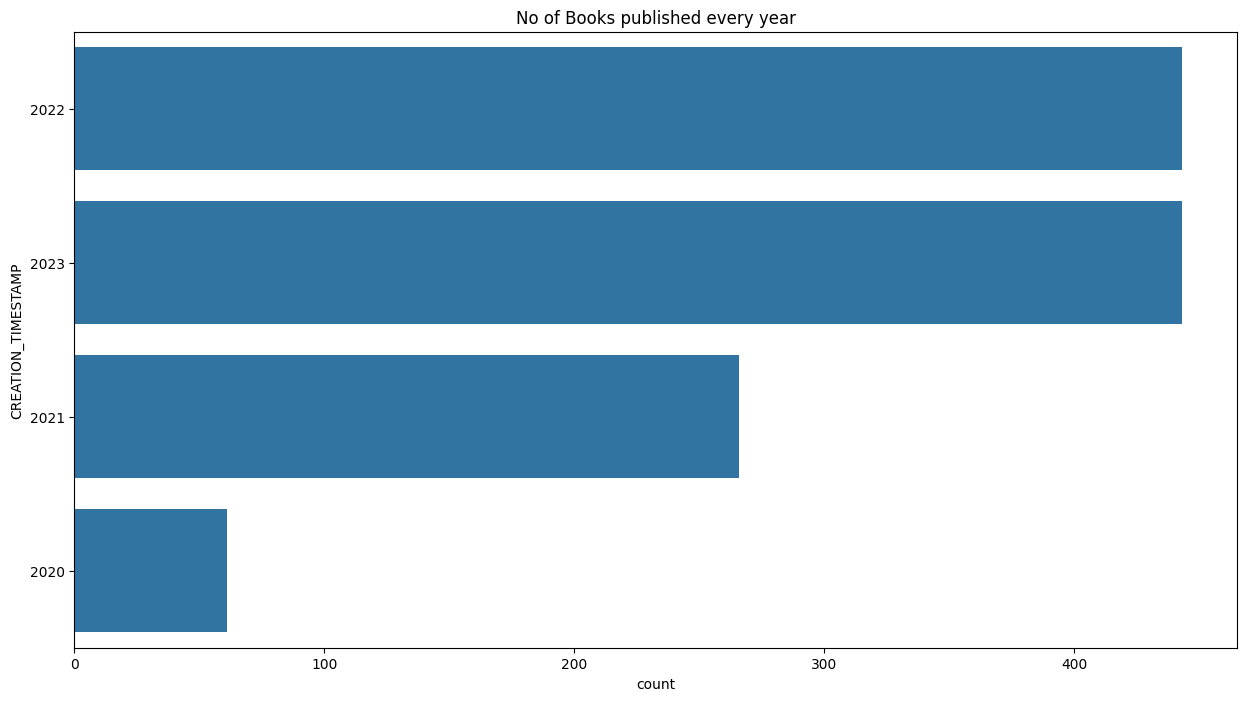

In [680]:
plt.figure(figsize=(15,8))
sns.countplot(y=BPC['CREATION_TIMESTAMP'], data=BPC,order=BPC['CREATION_TIMESTAMP'].value_counts().index[0:15])
plt.title("No of Books published every year")

#Additionally there are many visuals we can implement such as each year which type of book published, who is the author and who like it

In [681]:
#if we had user detail dataset then we can create visuals for user based on age, location, liked books, year wise activeness, type of book like etc although we dont have such information in current client data

**Recommendation Input**

In [682]:
#no of recomendation they expected from our recomendation system
number = int(input("Enter number of books to recommend: "))
#user id for recommendation 
user= int(input("Enter user id to recommend by user intrest using SVD: "))
#user id for recommendation 
book= str(input("Enter book name to recommend relvant books by cosine similarity: "))
#Input:Book Bite 3 How Do You Get Where You Want to Be  for 587


### Book Recommendation based on User Interest using SVD

The SVD(Singular Value Decomposition) is used as a collaborative filtering technique. It uses a matrix structure where each row represents a user, and each column represents an item. The elements of this matrix are the ratings that are given to items by users.

SVD and NMF models comparison Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

The name SurPRISE (roughly) stands for Simple Python Recommendation System Engine.

In [683]:
newer_books = BPC[BPC['CREATION_TIMESTAMP'] > 2000]

df_books = newer_books[['media_id','TITLE']]

# We are left with the ratings that have been made to the books from the year 2000.
df_ratings = rating[rating.media_id.isin(df_books.media_id)]

In [684]:
# Count the users that has voted more than 20 times. 
user_counts = df_ratings['user_id'].value_counts()
df_ratings = df_ratings[df_ratings['user_id'].isin(user_counts[user_counts >= 20].index)]

In [685]:
df_titles = df_books[['media_id','TITLE']]
df_titles.set_index('media_id', inplace = True)

In [686]:
def recommend_books(user_id):
    
    # Getting all the ratings that has done the user
    user = df_ratings[df_ratings['user_id'] == user_id]
    user = user.join(df_titles)['TITLE']
    
    user = df_titles.copy()
    user = user.reset_index()
    
    # We get the books that the user has not yet read. 
    user = user[~user['media_id'].isin(df_books)]
    
    # We check the predicted score using the predict function and getting the estimation.
    user['estimate_score'] = user['media_id'].apply(lambda x: algo.predict(user_id, x).est)
    
    # Sort the books by the estimate score that the predict returns.
    user = user.drop('media_id', axis=1)
    user = user.sort_values('estimate_score', ascending=False)
    
    return user.head(number)


In [687]:
reader = Reader()

data = Dataset.load_from_df(df_ratings[['user_id','media_id','liked']], reader)
kf = KFold(n_splits=5)
kf.split(data)
algo = SVD()
# Run 5-fold cross-validation and then print results
%time model_selection.cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
#analysis = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
#pd.DataFrame(analysis)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6993  1.7361  1.7422  1.7293  1.7556  1.7325  0.0187  
MAE (testset)     1.1352  1.1540  1.1555  1.1456  1.1671  1.1515  0.0106  
Fit time          0.92    0.93    0.97    0.95    0.96    0.95    0.02    
Test time         0.10    0.10    0.10    0.10    0.10    0.10    0.00    
CPU times: user 5.44 s, sys: 11.9 ms, total: 5.45 s
Wall time: 5.5 s


{'test_rmse': array([1.69928585, 1.73608756, 1.74224024, 1.72930357, 1.75562939]),
 'test_mae': array([1.13519341, 1.15402362, 1.15546863, 1.14564099, 1.16706458]),
 'fit_time': (0.9247848987579346,
  0.9297130107879639,
  0.9720587730407715,
  0.951610803604126,
  0.957280158996582),
 'test_time': (0.09863710403442383,
  0.10385417938232422,
  0.09819984436035156,
  0.10445809364318848,
  0.0998988151550293)}

In [688]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [689]:
user_id = user
recommend_books(user_id)

,TITLE,estimate_score
606,The Suite Spot Reaching Leading and Delivering...,5.0
355,Dream First Details Later How to Quit Overthin...,5.0
863,8 Rules of Love How to Find It Keep It and Let...,5.0
352,Subtract The Untapped Science of Less,5.0


***Taking an arbitrary user-id and item-id to test our model***

In [690]:
# Taking an arbitrary user-id and item-id to test our model.
#uid = 344  
#iid = 828
#pred = algo.predict(uid, iid, verbose=True)

In [691]:

#print(f'The estimated rating for the book with media id code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')


In [692]:
# train test split on our data
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# Fit the model
algo.fit(trainset)
# Predict the model on test data
predictions = algo.test(testset)
# Evaluating model
accuracy.rmse(predictions)

RMSE: 1.7208


1.7208058347883841

In [693]:
df_pred = pd.DataFrame(predictions, columns=['user_id', 'media_id', 'actual_rating', 'pred_rating', 'details'])
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred['actual_rating_round'] = df_pred['actual_rating'].round()
df_pred['pred_rating_round'] = df_pred['pred_rating'].round()
df_pred.drop(['details'], axis=1, inplace=True)
df_pred.sample(5)

,user_id,media_id,actual_rating,pred_rating,abs_err,actual_rating_round,pred_rating_round
9636,21560,115,2.023547,3.978581,1.955034,2.0,4.0
7547,21398,643,5.000000,4.281819,0.718181,5.0,4.0
615,42964,939,5.000000,4.979472,0.020528,5.0,5.0
1649,28136,191,5.000000,4.423109,0.576891,5.0,4.0
8202,19619,379,5.000000,5.000000,0.000000,5.0,5.0


Distribution of actual and predicted ratings in the test set According to the distribution of actual ratings of books in the test set, the biggest part of users give positive scores is 5.The mode equals 5 but count of ratings 0, 1 is also noticeable. The distribution of predicted ratings in the test set is visibly different. One more time, 5 is a mode but scores 0 and 1 are clearly less frequent. It shows that the recommender system is not perfect and it cannot reflect the real distribution of book ratings, but it is in acceptable stage as we are checking without domain expertise, only domain expertices/cleint provided cases can check the perfect evaluation of model

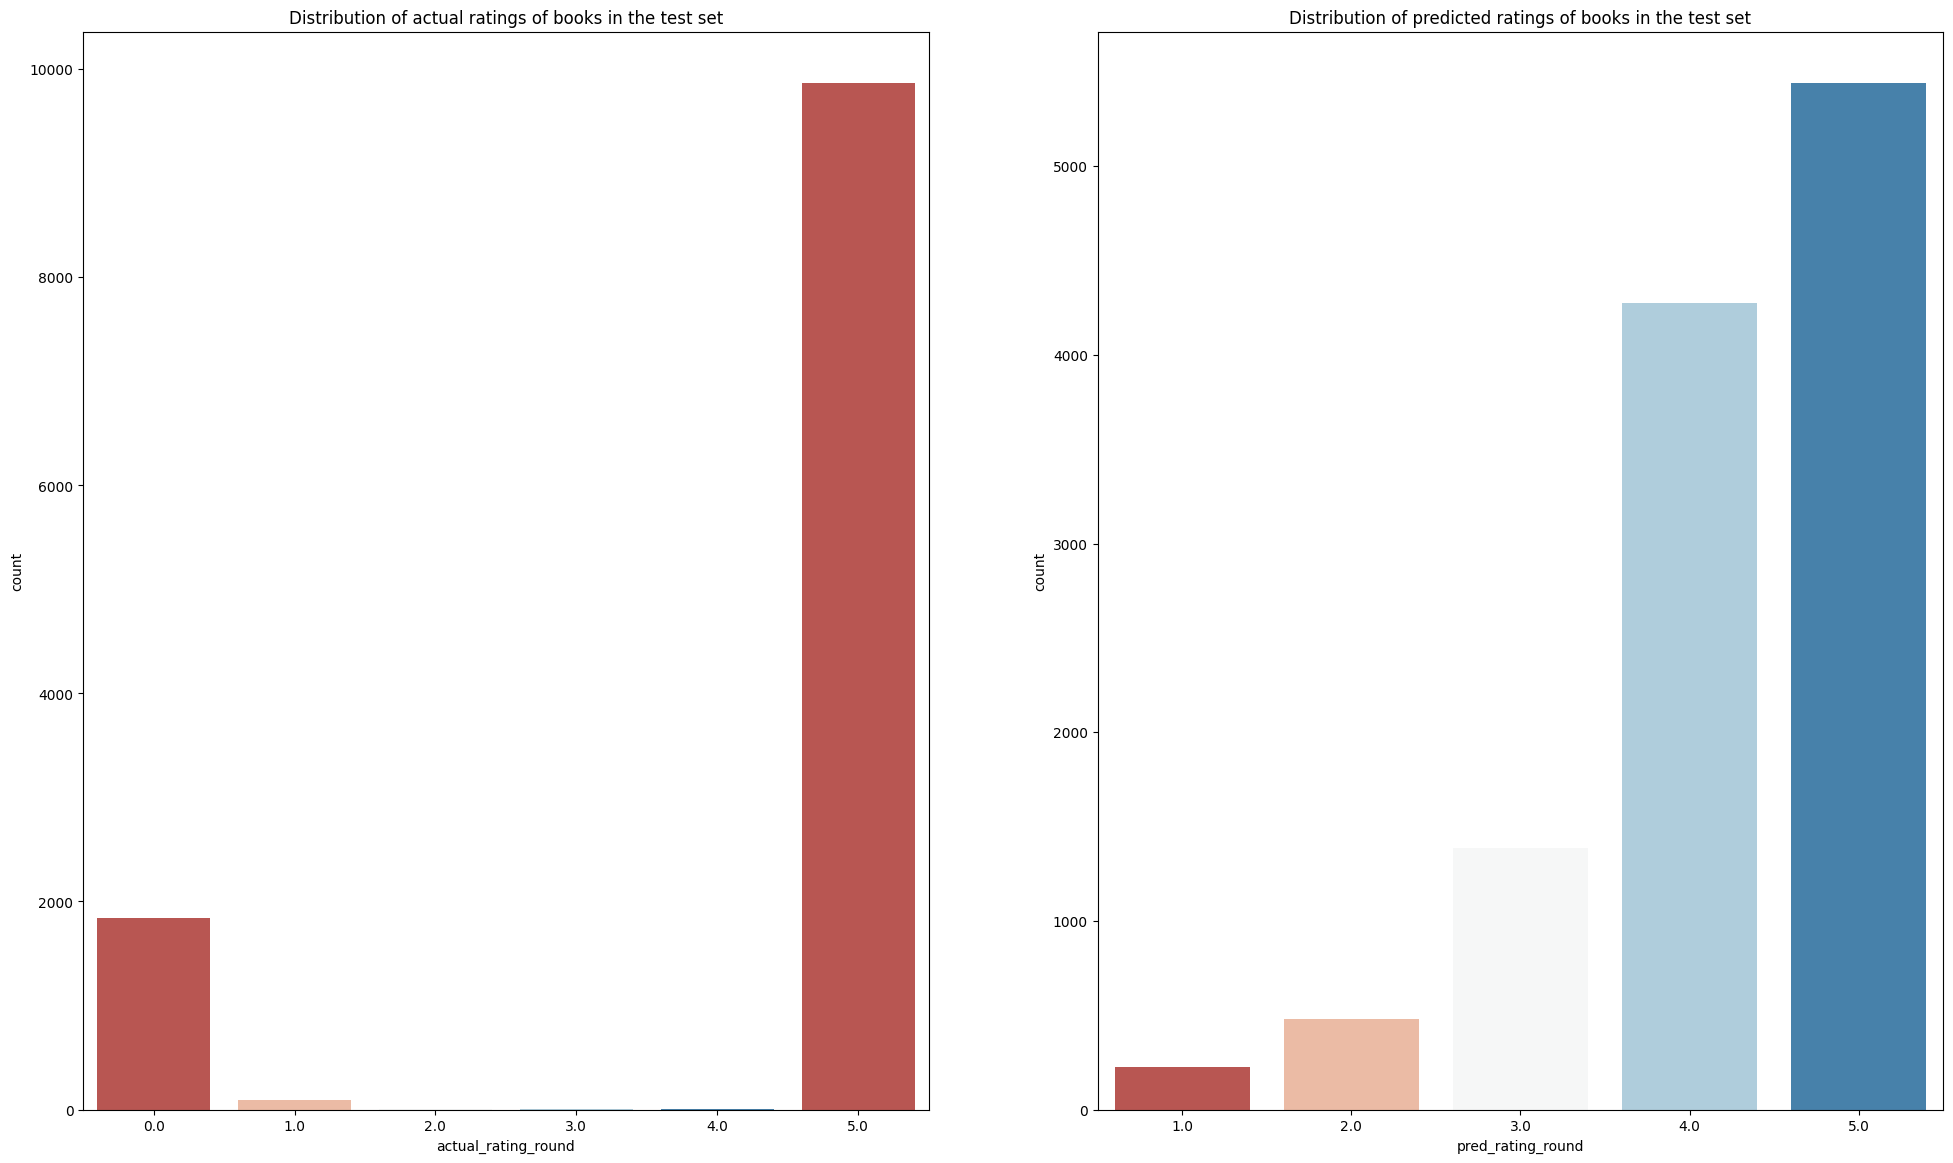

In [694]:

palette = sns.color_palette("RdBu", 5)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 14))

sns.countplot(x='actual_rating_round', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of books in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of books in the test set')

plt.show()

Absolute error of predicted ratings The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are several observations for which the absolute error was close to 5. How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 5(the most frequent value). The further the rating from score = 5, the higher the absolute error. The biggest errors happen to observations with scores 0 or 1 which indicates that probably the model is predicting high ratings for those observations. The reason behind is we have collected book datset by using liked/completed as 5 score and inprogress/watched as ranging from 0-5.

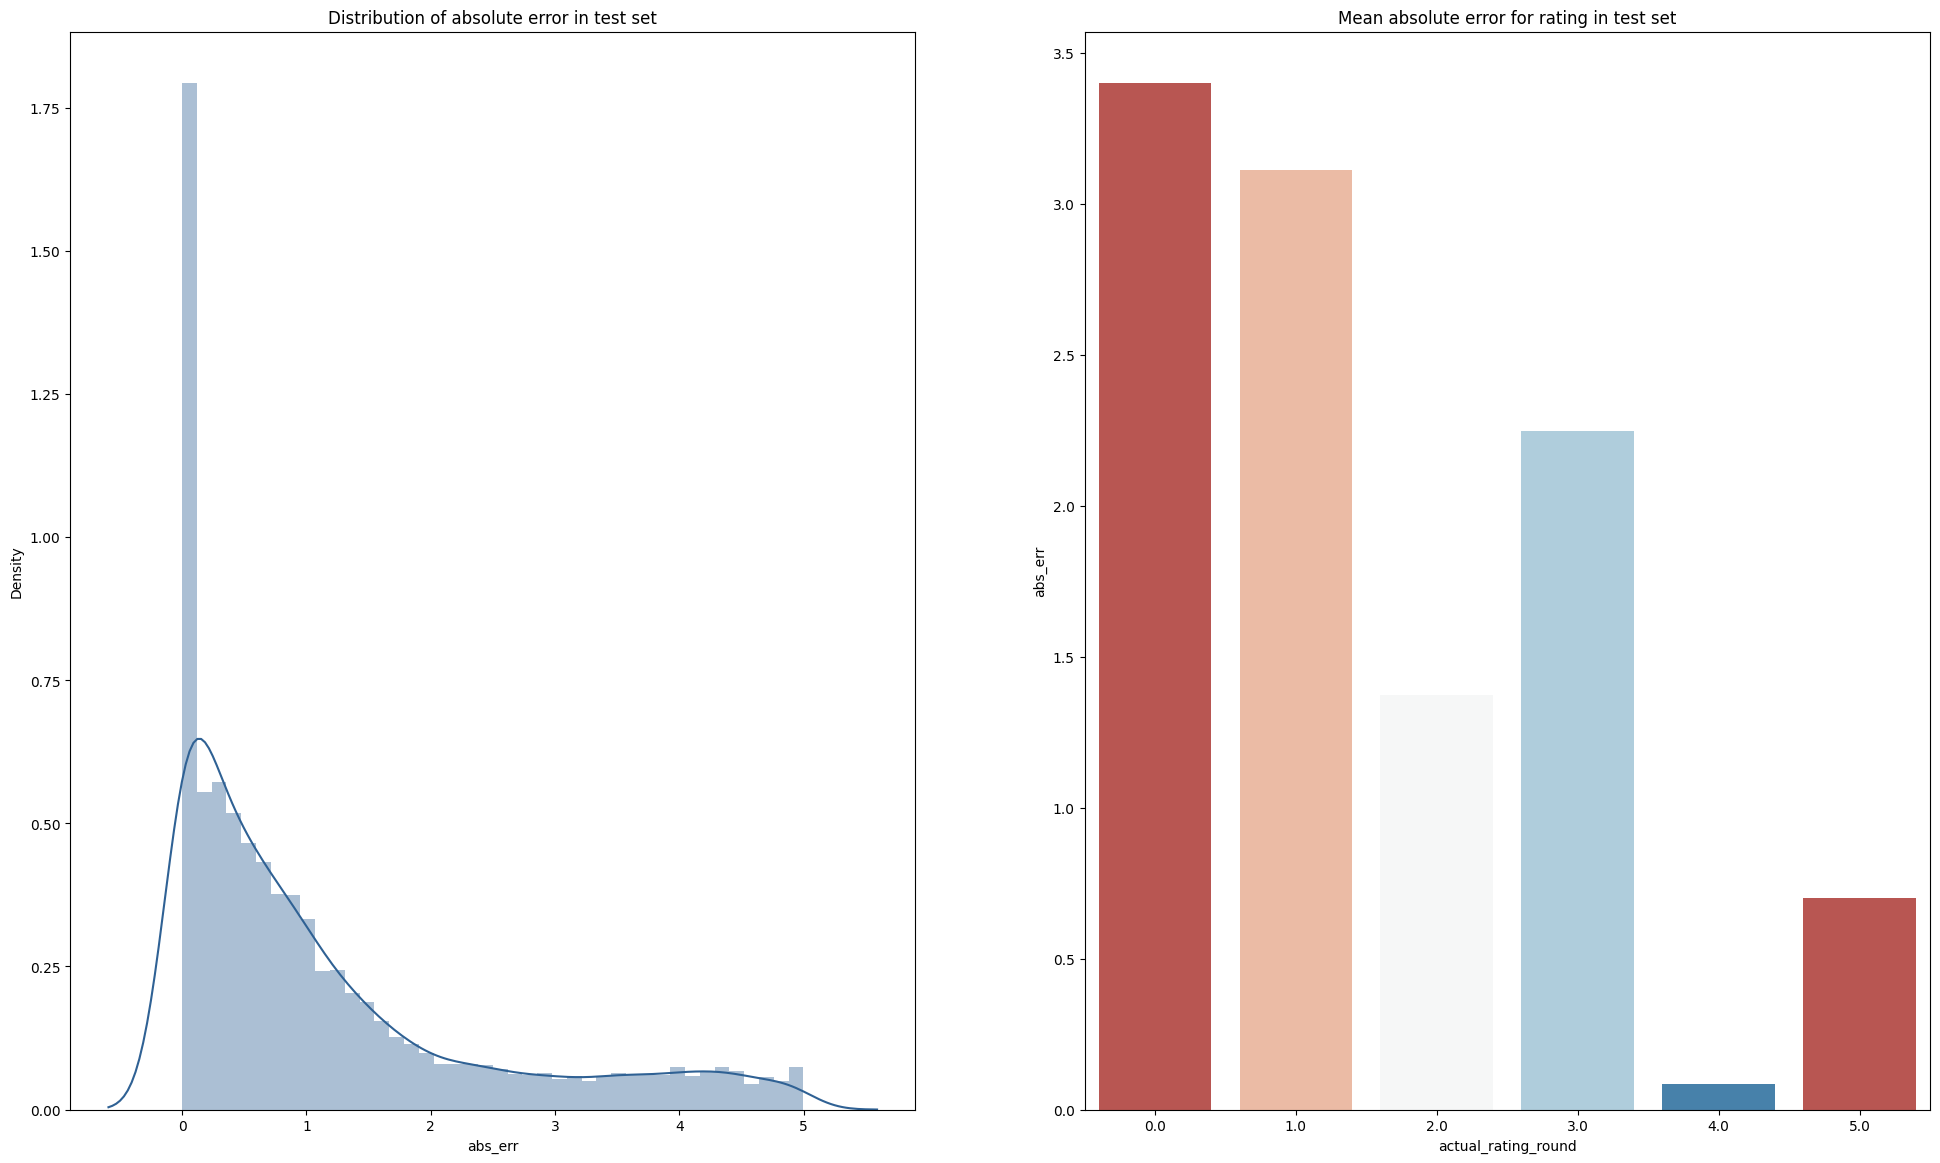

In [695]:
df_pred_err = df_pred.groupby('actual_rating_round')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24, 14))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating_round', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

In [696]:
# Merge ratings and books rating datasets
df = pd.merge(BPC, rating, on='media_id', how='inner')

# Take a look at the data
df.head()

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP,user_id,TIMESTAMP,EVENT_TYPE,liked
0,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,587,1656763579,NaN,5.00000
1,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,764,1657636529,NaN,5.00000
2,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,872,1655921829,NaN,0.01134
3,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,961,1660002881,NaN,5.00000
4,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,1058,1655588065,NaN,5.00000


 The rows of the matrix are books, and the columns of the matrix are users. The value of the matrix is the user rating of the book if there is a rating. Otherwise, it shows 'NaN'.

In [697]:
# Create user-item matrix
matrix = df.pivot_table(index='TITLE', columns='user_id', values='liked')
matrix.head()

user_id,0,141,192,226,344,345,353,357,360,361,...,57649,57651,57662,57670,57698,57704,57709,57735,57754,57846
TITLE,,,,,,,,,,,,,,,,,,,,,
1 Leadership Master the Small Daily Improvements that Set Great Leaders Apart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030 How Today s Biggest Trends Will Collide and Reshape the Future of Everything,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21 Lessons for the 21st Century,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28 Days to Save the World Crafting Your Culture to Be Ready for Anything,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8 Billion and Counting How Sex Death and Migration Shape Our World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data Normalization
In Step 5, we will normalize the data by subtracting the average rating of each book. The cosine similarity calculated based on the normalized data is called mean-centered cosine similarity.

After normalization, the ratings less than the book's average rating get a negative value, and the ratings more than the book's average rating get a positive value.

In [698]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 0)
matrix_norm.head()

user_id,0,141,192,226,344,345,353,357,360,361,...,57649,57651,57662,57670,57698,57704,57709,57735,57754,57846
TITLE,,,,,,,,,,,,,,,,,,,,,
1 Leadership Master the Small Daily Improvements that Set Great Leaders Apart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2030 How Today s Biggest Trends Will Collide and Reshape the Future of Everything,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21 Lessons for the 21st Century,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28 Days to Save the World Crafting Your Culture to Be Ready for Anything,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8 Billion and Counting How Sex Death and Migration Shape Our World,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***Calculate Similarity Score***

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this program, we will calculate the item similarity matrix using Pearson correlation.

In [699]:
# Item similarity matrix using Pearson correlation
item_similarity = matrix_norm.T.corr()
item_similarity.head()

TITLE,1 Leadership Master the Small Daily Improvements that Set Great Leaders Apart,2030 How Today s Biggest Trends Will Collide and Reshape the Future of Everything,21 Lessons for the 21st Century,28 Days to Save the World Crafting Your Culture to Be Ready for Anything,8 Billion and Counting How Sex Death and Migration Shape Our World,8 Rules of Love How to Find It Keep It and Let It Go,A Brief History of Earth Four Billion Years in Eight Chapters,A Brief History of the Female Body An Evolutionary Look at How and Why the Female Form Came to Be,A Cure for Darkness The Story of Depression and How We Treat It,A Hacker s Mind How the Powerful Bend Society s Rules and How to Bend them Back,...,You Should Smile More How to Dismantle Gender Bias in the Workplace,You Will Own Nothing Your War with a New Financial World Order and How to Fight Back,You and Your Adult Child How to Grow Together in Challenging Times,You re About to Make a Terrible Mistake How Biases Distort Decision Making and What You Can Do to Fight Them,Young and Restless The Girls Who Sparked America s Revolutions,Your Brain on Art How the Arts Transform Us,Your Face Belongs to Us A Secretive Startup s Quest to End Privacy as We Know It,Your Future Self How to Make Tomorrow Better Today,Your Life Depends On It What You Can Do to Make Better Choices About Your Health,Your Turn How to Be an Adult
TITLE,,,,,,,,,,,,,,,,,,,,,
1 Leadership Master the Small Daily Improvements that Set Great Leaders Apart,1.000000,NaN,NaN,-0.090909,NaN,0.353886,NaN,NaN,NaN,1.0,...,NaN,0.472299,0.362904,NaN,-0.058824,-0.142797,0.491347,0.710554,0.330233,-0.099498
2030 How Today s Biggest Trends Will Collide and Reshape the Future of Everything,NaN,1.000000,0.422545,-0.111111,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.111111,-0.083333,-0.125000,NaN,NaN,-0.111111,NaN,-0.111111,0.596541,NaN
21 Lessons for the 21st Century,NaN,0.422545,1.000000,0.671964,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.886686,0.322562
28 Days to Save the World Crafting Your Culture to Be Ready for Anything,-0.090909,-0.111111,0.671964,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.188982,NaN,NaN,-0.315374,NaN,NaN,-0.134549,NaN,NaN
8 Billion and Counting How Sex Death and Migration Shape Our World,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


cosine_similarity does not take missing values, we need to impute the missing values with 0s before the calculation.

In [700]:
# Item similarity matrix using cosine similarity
item_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
item_similarity_cosine

array([[ 1.        ,  0.01240392,  0.01277522, ...,  0.07714539,
         0.02460211, -0.00694564],
       [ 0.01240392,  1.        ,  0.02262572, ..., -0.00228211,
         0.06285695,  0.00708627],
       [ 0.01277522,  0.02262572,  1.        , ...,  0.01345354,
         0.06469296,  0.02950149],
       ...,
       [ 0.07714539, -0.00228211,  0.01345354, ...,  1.        ,
         0.01225997,  0.01898182],
       [ 0.02460211,  0.06285695,  0.06469296, ...,  0.01225997,
         1.        ,  0.03856841],
       [-0.00694564,  0.00708627,  0.02950149, ...,  0.01898182,
         0.03856841,  1.        ]])

In the book similarity matrix, the values range from -1 to 1, where -1 means opposite book similarity and 1 means very high book similarity.

***Predict User's Rating For One book***

we will predict a user's rating for one book.

The prediction follows the process below:

Create a list of the book that user has watched and rated.
Rank the similarities between the book user rated and book enterd.
Select top n book with highest similarity scores.
Calculate the predicted rating using weighted average of similarity scores and the ratings from user .
Now let's implement the process using Python.

Firstly, we removed all the book that have a missing rating for user , and sorted the book by the ratings.

In [701]:
# Pick a user ID
picked_userid = user

# Pick a book
picked_book = book

# book that the target user has watched
picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                          .sort_values(ascending=False))\
                          .reset_index()\
                          .rename(columns={587:'rating'})

picked_userid_watched.head()

,TITLE,rating
0,Lead with We The Business Revolution That Will...,4.010813
1,Provoke How Leaders Shape the Future by Overco...,3.529154
2,Think Talk Create Building Workplaces Fit For ...,3.510134
3,Wellbeing at Work How to Build Resilient and T...,2.428317
4,Boundless Leadership The Breakthrough Method t...,2.384462


users watched top 5 book with the highest similarity score.

In [702]:
# Similarity score of the book enterd with all the other book
picked_book_similarity_score = item_similarity[[picked_book]].reset_index().rename(columns={user:'rating',book:'similarity_score'})

# Rank the similarities between the book user rated and enterd book.
n = 5
picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                            right=picked_book_similarity_score, 
                                            on='TITLE', 
                                            how='inner')\
                                     .sort_values('similarity_score', ascending=False)[:5]

picked_userid_watched_similarity

,TITLE,rating,similarity_score
51,Leading from Anywhere The Essential Guide to M...,1.060950,1.000000
48,The Investing Oasis Contrarian Treasures in th...,1.093767,1.000000
52,Book Bite 3 How Do You Get Where You Want to Be,1.060950,1.000000
49,Moonshot Inside Pfizer s Nine Month Race to Ma...,1.092840,0.739767
89,The Age Proof Brain New Strategies to Improve ...,0.794148,0.650728


In [703]:
# Calculate the predicted rating using weighted average of similarity scores and the ratings from user 
predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                    weights=picked_userid_watched_similarity['similarity_score']), 6)

print(f'The predicted rating for {picked_book} by user {picked_userid} is {predicted_rating}' )

The predicted rating for Book Bite 3 How Do You Get Where You Want to Be by user 587 is 1.034254


we will create an item-item book recommendation system following four steps:

Create a list of book that the target user has not watched before.

Loop through the unwatched book and create predicted scores for each book.

Rank the predicted score of unwatched book from high to low.

Select the top k book as the recommendations for the target user.

The Python function below implemented the four steps. With the input of picked_userid, number_of_similar_items, and number_of_recommendations, we can get the top book for the user and their corresponding ratings. Note that the ratings are normalized by extracting the average rating for the book, so we need to add the average value back to the predicted ratings if we want the predicted ratings to be on the same scale as the original ratings.

In [704]:
# Item-based recommendation function
def item_based_rec(picked_userid, number_of_similar_items, number_of_recommendations ):
  import operator
  # book that the target user has not watched
  picked_userid_unwatched = pd.DataFrame(matrix_norm[picked_userid].isna()).reset_index()
  picked_userid_unwatched = picked_userid_unwatched[picked_userid_unwatched[user]==True]['TITLE'].values.tolist()

  # book that the target user has watched
  picked_userid_watched = pd.DataFrame(matrix_norm[picked_userid].dropna(axis=0, how='all')\
                            .sort_values(ascending=False))\
                            .reset_index()\
                            .rename(columns={user:'rating'})
  
  # Dictionary to save the unwatched book and predicted rating pair
  rating_prediction ={}  

  # Loop through unwatched book          
  for picked_book in picked_userid_unwatched: 
    # Calculate the similarity score of the picked book iwth other book
    picked_book_similarity_score = item_similarity[[picked_book]].reset_index().rename(columns={picked_book:'similarity_score'})
    # Rank the similarities between the picked user watched book and the picked unwatched book.
    picked_userid_watched_similarity = pd.merge(left=picked_userid_watched, 
                                                right=picked_book_similarity_score, 
                                                on='TITLE', 
                                                how='inner')\
                                        .sort_values('similarity_score', ascending=False)[:number_of_similar_items]
    # Calculate the predicted rating using weighted average of similarity scores and the ratings from user 
    predicted_rating = round(np.average(picked_userid_watched_similarity['rating'], 
                                        weights=picked_userid_watched_similarity['similarity_score']), 6)
    # Save the predicted rating in the dictionary
    rating_prediction[picked_book] = predicted_rating
    # Return the top recommended book
  return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_recommendations]

# Get recommendations
recommended_book = item_based_rec(user,number, number)
recommended_book


[('STFU The Power of Keeping Your Mouth Shut in a World That Won t Stop Talking',
  2.579161),
 ('The Most Powerful You 7 Bravery Boosting Paths to Career Bliss', 2.429125),
 ('Astrotopia The Dangerous Religion of the Corporate Space Race', 2.379787),
 ('The Anatomy of Anxiety Understanding and Overcoming the Body s Fear Response',
  2.374768)]